In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/ML_Challenge_Seg")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q segmentation-models-pytorch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time 
from tqdm.notebook import tqdm
from torchsummary import summary
import segmentation_models_pytorch as smp

device =torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
images= "image_chips/"
targets= "target_data/"

n_classes = 2

def _df_():
  name = []
  for dirname ,_ , filenames in os.walk(images):
    for filename in filenames:
      name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id':name} , index = np.arange(0, len(name)))

df = _df_()
print(len(df))

100


In [5]:
X_train , X_val = train_test_split(df['id'].values , test_size
                                   =0.1 , random_state =19)
print(f'Train : {len(X_train)}')
print(f'Val : {len(X_val)}')

Train : 90
Val : 10


Image Size (750, 750, 3)
Mask Size (750, 750)


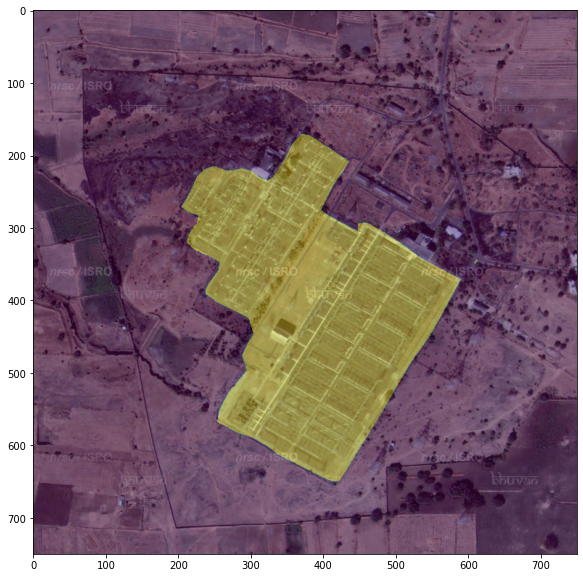

In [6]:
img = Image.open(images + df['id'][99] + '.jpg')
targ = Image.open(targets + df['id'][99] + '.jpg')

print('Image Size', np.asarray(img).shape)
print('Mask Size' , np.asarray(targ).shape)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(targ , alpha =0.4)
plt.show()

In [7]:
def dense_target(tar: np.ndarray):
    classes =np.unique(tar)
    dummy= np.zeros_like(tar)
    for idx , value in enumerate(classes):
        mask = np.where(tar == value)
        dummy[mask] = idx
    return dummy

class SegData(Dataset):

  def __init__(self , image_path , target_path , X , mean , std , transform =None , test=False):
    self.image_path = image_path
    self.target_path = target_path
    self.X = X
    self.transform =transform
    self.mean = mean
    self.std = std
    self.test =test

  def __len__(self):
    return len(self.X)
  

  def __getitem__(self, idx):
    img = cv2.cvtColor(cv2.imread(self.image_path + self.X[idx] + '.jpg') , cv2.COLOR_BGR2RGB)
    target = cv2.imread(self.target_path + self.X[idx] + '.jpg' , cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (768 , 768) , interpolation = cv2.INTER_NEAREST)
    target = cv2.resize(target , (768 , 768), interpolation = cv2.INTER_NEAREST)
    target = np.where( target > 0,255,0)
  
    if self.transform is not None:
      aug = self.transform(image = img , target = target )
      img = Image.fromarray(aug['image'])
      target = aug['target']
    
    if self.transform is None:
      img = Image.fromarray(img) 
    
    t = T.Compose([T.ToTensor() , T.Normalize(self.mean , self.std)])
    
    if self.test is False:
      img = t(img)
    target = dense_target(target)
    target = torch.from_numpy(target).long()
    return img ,target



In [8]:
mean = [0.485 ,0.456 ,0.406]
std = [0.229 , 0.224 , 0.225]

train_transforms = A.Compose([A.HorizontalFlip(), A.VerticalFlip(),
A.RandomBrightnessContrast((0,0.5), (0, 0.5)) , A.GaussNoise(), A.GridDistortion(p=0.2)])

val_transforms = A.Compose([A.HorizontalFlip() , A.GridDistortion(p=0.2)])

train_set = SegData(images, targets, X_train , mean, std , train_transforms)
val_set = SegData(images , targets , X_val , mean , std , val_transforms)

batch_size =4
train_loader= DataLoader(train_set , batch_size= batch_size , shuffle =True)
val_loader = DataLoader(val_set , batch_size = batch_size , shuffle =True)

In [9]:
x , y =next(iter(train_loader))

print(f' x = shape : {x.shape} ; type :{x.dtype}')
print(f' x = min : {x.min()} ; max : {x.max()}')
print(f' y = shape: {y.shape}; class : {y.unique()}; type: {y.dtype}')

 x = shape : torch.Size([4, 3, 768, 768]) ; type :torch.float32
 x = min : -2.1179039478302 ; max : 2.640000104904175
 y = shape: torch.Size([4, 768, 768]); class : tensor([0, 1]); type: torch.int64


In [10]:
model = smp.Unet('mobilenet_v2' , encoder_weights='imagenet' , classes=2, activation=None,
                 encoder_depth= 5 , decoder_channels=[256, 128, 64, 32, 16])
model=model.to(device)

In [11]:
summary(model, input_size=(3, 512 , 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             864
       BatchNorm2d-2         [-1, 32, 256, 256]              64
             ReLU6-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 32, 256, 256]             288
       BatchNorm2d-5         [-1, 32, 256, 256]              64
             ReLU6-6         [-1, 32, 256, 256]               0
            Conv2d-7         [-1, 16, 256, 256]             512
       BatchNorm2d-8         [-1, 16, 256, 256]              32
  InvertedResidual-9         [-1, 16, 256, 256]               0
           Conv2d-10         [-1, 96, 256, 256]           1,536
      BatchNorm2d-11         [-1, 96, 256, 256]             192
            ReLU6-12         [-1, 96, 256, 256]               0
           Conv2d-13         [-1, 96, 128, 128]             864
      BatchNorm2d-14         [-1, 96, 1

In [12]:
def pixel_wise_accuracy(output , mask):
  with torch.no_grad():
    output = torch.argmax(F.softmax(output , dim =1) , dim=1)
    correct = torch.eq(output , mask).int()
    accuracy = float(correct.sum())/ float(correct.numel())#total number
  return accuracy

In [13]:
def IoU(pred , true_pred , smooth =1e-10 , n_classes=2):
  with torch.no_grad():
    pred = torch.argmax(F.softmax(pred , dim =1) , dim=1)
    pred = pred.contiguous().view(-1)
    true_pred = true_pred.contiguous().view(-1)

    iou_class = []
    for value in range(0, n_classes):
      true_class = pred == value
      true_label = true_pred == value

      if true_label.long().sum().item()==0:
        iou_class.append(np.nan)
        
      else:
    
        inter = torch.logical_and(true_class, true_label).sum().float().item()
        union = torch.logical_or(true_class , true_label).sum().float().item()

        iou = (inter + smooth)/(union + smooth)
        iou_class.append(iou)

    return np.nanmean(iou_class)
 

In [14]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += IoU(output, mask)
            accuracy += pixel_wise_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  IoU(output, mask)
                    test_accuracy += pixel_wise_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenetv2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss did not  Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss did not decrease for the 7th time , Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train IoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val IoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [15]:
max_lr = 1e-3
epoch = 25
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)


Loss Decreasing.. inf >> 1.220 
Epoch:1/25.. Train Loss: 0.875.. Val Loss: 1.220.. Train IoU:0.251.. Val IoU: 0.270.. Train Acc:0.442.. Val Acc:0.471.. Time: 0.26m



Loss Decreasing.. 1.220 >> 0.570 
Epoch:2/25.. Train Loss: 0.610.. Val Loss: 0.570.. Train IoU:0.403.. Val IoU: 0.469.. Train Acc:0.686.. Val Acc:0.771.. Time: 0.26m



Loss Decreasing.. 0.570 >> 0.325 
Epoch:3/25.. Train Loss: 0.394.. Val Loss: 0.325.. Train IoU:0.550.. Val IoU: 0.615.. Train Acc:0.897.. Val Acc:0.928.. Time: 0.26m



Loss Decreasing.. 0.325 >> 0.216 
saving model...
Epoch:4/25.. Train Loss: 0.256.. Val Loss: 0.216.. Train IoU:0.550.. Val IoU: 0.640.. Train Acc:0.924.. Val Acc:0.921.. Time: 0.27m



Loss Decreasing.. 0.216 >> 0.191 
Epoch:5/25.. Train Loss: 0.210.. Val Loss: 0.191.. Train IoU:0.606.. Val IoU: 0.560.. Train Acc:0.925.. Val Acc:0.931.. Time: 0.26m



Loss did not  Decrease for 1 time
Epoch:6/25.. Train Loss: 0.209.. Val Loss: 0.193.. Train IoU:0.522.. Val IoU: 0.651.. Train Acc:0.919.. Val Acc:0.932.. Time: 0.27m



Loss did not  Decrease for 2 time
Epoch:7/25.. Train Loss: 0.195.. Val Loss: 0.241.. Train IoU:0.598.. Val IoU: 0.610.. Train Acc:0.929.. Val Acc:0.910.. Time: 0.25m



Loss Decreasing.. 0.241 >> 0.218 
Epoch:8/25.. Train Loss: 0.195.. Val Loss: 0.218.. Train IoU:0.563.. Val IoU: 0.616.. Train Acc:0.925.. Val Acc:0.897.. Time: 0.25m



Loss Decreasing.. 0.218 >> 0.183 
Epoch:9/25.. Train Loss: 0.191.. Val Loss: 0.183.. Train IoU:0.564.. Val IoU: 0.608.. Train Acc:0.922.. Val Acc:0.924.. Time: 0.27m



Loss did not  Decrease for 3 time
Epoch:10/25.. Train Loss: 0.187.. Val Loss: 0.195.. Train IoU:0.595.. Val IoU: 0.585.. Train Acc:0.928.. Val Acc:0.923.. Time: 0.27m



Loss Decreasing.. 0.195 >> 0.166 
Epoch:11/25.. Train Loss: 0.197.. Val Loss: 0.166.. Train IoU:0.603.. Val IoU: 0.654.. Train Acc:0.927.. Val Acc:0.941.. Time: 0.26m



Loss did not  Decrease for 4 time
Epoch:12/25.. Train Loss: 0.173.. Val Loss: 0.174.. Train IoU:0.640.. Val IoU: 0.650.. Train Acc:0.935.. Val Acc:0.926.. Time: 0.25m



Loss did not  Decrease for 5 time
Epoch:13/25.. Train Loss: 0.175.. Val Loss: 0.189.. Train IoU:0.624.. Val IoU: 0.563.. Train Acc:0.929.. Val Acc:0.926.. Time: 0.27m



Loss Decreasing.. 0.189 >> 0.169 
saving model...
Epoch:14/25.. Train Loss: 0.161.. Val Loss: 0.169.. Train IoU:0.663.. Val IoU: 0.669.. Train Acc:0.936.. Val Acc:0.934.. Time: 0.27m



Loss Decreasing.. 0.169 >> 0.120 
Epoch:15/25.. Train Loss: 0.167.. Val Loss: 0.120.. Train IoU:0.624.. Val IoU: 0.715.. Train Acc:0.933.. Val Acc:0.962.. Time: 0.26m



Loss did not  Decrease for 6 time
Epoch:16/25.. Train Loss: 0.165.. Val Loss: 0.193.. Train IoU:0.641.. Val IoU: 0.616.. Train Acc:0.936.. Val Acc:0.918.. Time: 0.26m



Loss Decreasing.. 0.193 >> 0.145 
Epoch:17/25.. Train Loss: 0.158.. Val Loss: 0.145.. Train IoU:0.669.. Val IoU: 0.643.. Train Acc:0.936.. Val Acc:0.949.. Time: 0.27m



Loss did not  Decrease for 7 time
Loss did not decrease for the 7th time , Stop Training
Total time: 4.73 m


In [16]:
#torch.save(model , './model.pth')
#model = torch.load('./unet.pt')

In [17]:
test_set = SegData(images, targets, X_val ,mean , std, transform = None , test = True)

In [18]:
def predict_image_mask(model, image , mask , mean=[0.485, 0.456, 0.406],
                       std = [0.229 , 0.224 ,0.225]):
  model.eval()
  t= T.Compose([T.ToTensor() ,T.Normalize(mean, std)])
  image = t(image)
  model.to(device) ; image = image.to(device)
  mask = mask.to(device)
  with torch.no_grad():

    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    output = model(image)
    score = IoU(output, mask)
    masked = torch.argmax(output , dim =1)
    masked = masked.cpu().squeeze(0)
  return masked , score


In [23]:
image , mask = test_set[4]
pred_mask , score = predict_image_mask(model , image , mask)

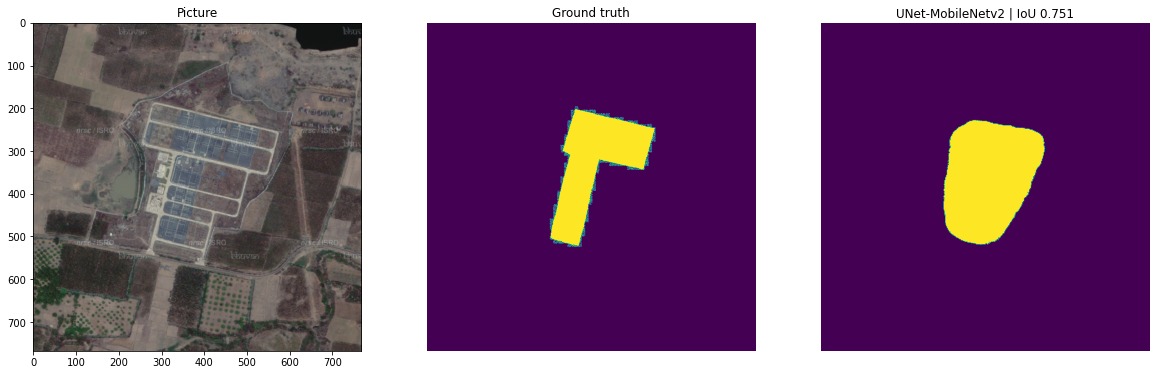

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNetv2 | IoU {:.3f}'.format(score))
ax3.set_axis_off()